In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cell 0 – Imports & Config

In [39]:
# Cell 0: Imports & basic config
# ==============================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import joblib
import json

print("TF version:", tf.__version__)

TF version: 2.19.0


### Cell 1 – Load Dataset

In [40]:
# Cell 1: Load dataset
# ====================

DATA_PATH = "/content/drive/MyDrive/Absher Tuwaiq/shadow_id_v2_English_Dataset.csv"  # Path

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (4000, 24)


,RowID,PersonType,PersonTypeCode,IDNumber,Nationality,NameShort,Phone,Location,Latitude,Longitude,...,TokenEndTime,UsageTime,TokenDurationMinutes,UsedWithinValidity,DeviceId,State,StateArabic,RiskLabel,RiskReason,FraudType
0,3385,Resident,2,2676743889,Filipino,Aaron B.,545183616,Jazan,16.8895,42.5700,...,10/19/2025 12:27,10/19/2025 12:17,15,1,DEV-52853004,Active,فعال,Low,NaN,NaN
1,2790,Citizen,1,1206743219,Saudi,Aaron B.,533094606,Dammam,26.4207,50.0888,...,6/13/2025 15:04,6/13/2025 14:54,15,1,DEV-14444657,Suspicious,مشبوه,High,Abnormal request frequency,FrequentGeneration
2,2820,Citizen,1,1366671176,Saudi,Aaron B.,521903576,Abha,18.2465,42.5117,...,3/10/2024 23:04,3/10/2024 22:50,15,1,DEV-83256618,Active,فعال,Low,NaN,NaN
3,2319,Resident,2,2282580601,Indian,Aaron C.,538102644,Jazan,16.8895,42.5700,...,9/15/2024 4:08,9/15/2024 5:31,15,0,DEV-95307277,Expired,منتهي,Medium,Token Expired,NaN
4,3778,Resident,2,2777405890,Pakistani,Aaron C.,580898513,Jazan,16.8895,42.5700,...,11/10/2025 15:40,11/10/2025 15:25,15,1,DEV-48764273,Active,فعال,Low,NaN,NaN


### Cell 2 – Datetime Processing & Feature Engineering

In [41]:
# Cell 2: Datetime processing & Feature Engineering
# ==============================================

# 1) تحويل أعمدة الوقت إلى datetime
date_cols = [
    "IssueDate", "ExpiryDate",
    "TokenStartTime", "TokenEndTime", "UsageTime"
]
existing_date_cols = [c for c in date_cols if c in df.columns]

for c in existing_date_cols:
    df[c] = pd.to_datetime(df[c])

# 2) Features زمنية إضافية تساعد المودل يفهم سلوك الاستخدام

# كم دقيقة مرت من بداية صلاحية التوكن حتى الاستخدام
if set(["UsageTime", "TokenStartTime"]).issubset(df.columns):
    df["TimeFromStartMin"] = (df["UsageTime"] - df["TokenStartTime"]).dt.total_seconds() / 60.0

# هل التوكن كان منتهي وقت الاستخدام؟
if set(["UsageTime", "TokenEndTime"]).issubset(df.columns):
    df["IsExpiredAtUse"] = (df["UsageTime"] > df["TokenEndTime"]).astype(int)

# ساعة و يوم الاستخدام (سلوك الاستخدام حسب الوقت)
if "TokenStartTime" in df.columns:
    df["TokenStartHour"] = df["TokenStartTime"].dt.hour
if "UsageTime" in df.columns:
    df["UsageHour"] = df["UsageTime"].dt.hour
    df["UsageWeekday"] = df["UsageTime"].dt.weekday

print("✅ Datetime & feature engineering done.")
df.head()

✅ Datetime & feature engineering done.


,RowID,PersonType,PersonTypeCode,IDNumber,Nationality,NameShort,Phone,Location,Latitude,Longitude,...,State,StateArabic,RiskLabel,RiskReason,FraudType,TimeFromStartMin,IsExpiredAtUse,TokenStartHour,UsageHour,UsageWeekday
0,3385,Resident,2,2676743889,Filipino,Aaron B.,545183616,Jazan,16.8895,42.5700,...,Active,فعال,Low,NaN,NaN,5.0,0,12,12,6
1,2790,Citizen,1,1206743219,Saudi,Aaron B.,533094606,Dammam,26.4207,50.0888,...,Suspicious,مشبوه,High,Abnormal request frequency,FrequentGeneration,5.0,0,14,14,4
2,2820,Citizen,1,1366671176,Saudi,Aaron B.,521903576,Abha,18.2465,42.5117,...,Active,فعال,Low,NaN,NaN,1.0,0,22,22,6
3,2319,Resident,2,2282580601,Indian,Aaron C.,538102644,Jazan,16.8895,42.5700,...,Expired,منتهي,Medium,Token Expired,NaN,98.0,1,3,5,6
4,3778,Resident,2,2777405890,Pakistani,Aaron C.,580898513,Jazan,16.8895,42.5700,...,Active,فعال,Low,NaN,NaN,0.0,0,15,15,0


### Cell 3 – Drop Columns, One-Hot Encoding, Scaling

In [42]:
# Cell 3: Drop cols + One-Hot + Scale
# ===================================

# الأعمدة اللي ما نبيها كـ Features رقمية
drop_cols = [
    "RowID",
    "NameShort",
    "Phone",
    "IDNumber",
    "TokenId",
    "DeviceId",
    "RiskReason",    # هذا للنصوص / LLM فقط
    "StateArabic",   # النسخة العربية من الحالة
]

# نتأكد من وجود label
label_col = "RiskLabel" if "RiskLabel" in df.columns else None

# لو نبغى الـ Autoencoder يكون Unsupervised تمامًا نشيل RiskLabel من X
if label_col is not None:
    drop_cols.append(label_col)

# نشيل أعمدة التواريخ الأصلية (بعد ما استخرجنا منها features رقمية)
drop_cols.extend(existing_date_cols)

# نتأكد إن الأعمدة موجودة قبل ما نحذفها
existing_drop_cols = [c for c in drop_cols if c in df.columns]
df_features = df.drop(columns=existing_drop_cols)

print("✅ Features dataframe shape after drops:", df_features.shape)
print("Remaining columns:", df_features.columns.tolist())

# --- Categorical encoding (One-Hot) ---
cat_cols = []
for c in ["PersonType", "Nationality", "Location", "FraudType", "State"]:
    if c in df_features.columns:
        cat_cols.append(c)

print("Categorical columns:", cat_cols)

df_model = pd.get_dummies(df_features, columns=cat_cols, drop_first=True)
print("✅ After get_dummies, shape:", df_model.shape)

# Feature matrix
X = df_model.values
feature_names = df_model.columns.tolist()
print("Feature matrix shape:", X.shape)

# Train / Test split (بدون Labels، لأن الأوتوإنكودر Unsupervised)
X_train, X_test = train_test_split(
    X, test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("✅ Scaling done.")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

✅ Features dataframe shape after drops: (4000, 15)
Remaining columns: ['PersonType', 'PersonTypeCode', 'Nationality', 'Location', 'Latitude', 'Longitude', 'TokenDurationMinutes', 'UsedWithinValidity', 'State', 'FraudType', 'TimeFromStartMin', 'IsExpiredAtUse', 'TokenStartHour', 'UsageHour', 'UsageWeekday']
Categorical columns: ['PersonType', 'Nationality', 'Location', 'FraudType', 'State']
✅ After get_dummies, shape: (4000, 32)
Feature matrix shape: (4000, 32)
✅ Scaling done.
X_train_scaled: (3200, 32)
X_test_scaled: (800, 32)


## Cell 4 – Build Autoencoder

In [43]:
# Cell 4: Build Autoencoder
# =========================

input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # حجم الـ embedding (تم اعتماده)

input_layer = keras.Input(shape=(input_dim,), name="input")

# Encoder
encoded = layers.Dense(64, activation="relu")(input_layer)
encoded = layers.Dense(32, activation="relu")(encoded)
bottleneck = layers.Dense(encoding_dim, activation="relu", name="risk_embedding")(encoded)

# Decoder
decoded = layers.Dense(32, activation="relu")(bottleneck)
decoded = layers.Dense(64, activation="relu")(decoded)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

autoencoder = keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="shadow_id_autoencoder"
)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "shadow_id_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ risk_embedding (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,456 (36.94 KB)

 Trainable params: 9,456 (36.94 KB)

 Non-trainable params: 0 (0.00 B)

### Cell 5 – Train Autoencoder (50 Epochs + Plot Loss)

In [44]:
# Cell 5: Train Autoencoder (50 epochs)
# =====================================

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

print("✅ Training finished.")


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9537 - val_loss: 0.8258
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7786 - val_loss: 0.5666
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5275 - val_loss: 0.4212
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3918 - val_loss: 0.3275
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3067 - val_loss: 0.2682
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2514 - val_loss: 0.2242
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2088 - val_loss: 0.1924
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1776 - val_loss: 0.1676
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1546 - val_loss: 0.1439
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1355 - val_loss: 0.1275
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1244 - val_loss: 0.1186
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1134 - val_l

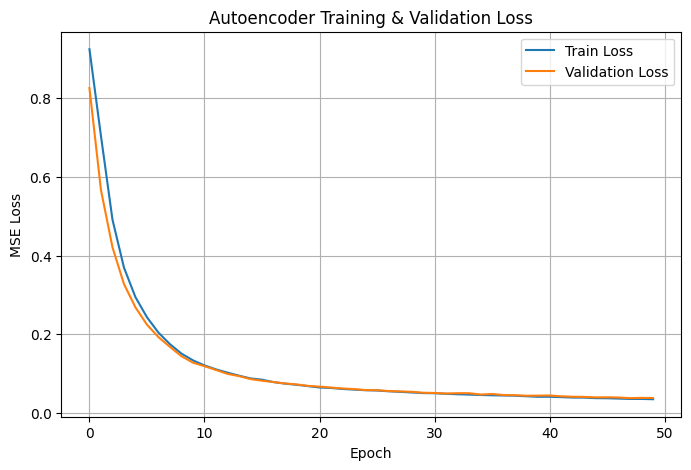

In [45]:
# Cell 5.1: Plot training vs validation loss
# ==========================================

train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#Cell 6 – 10-Fold Cross-Validation -> To showing the resault
# ==============================================================

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_losses = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    print(f"\n===== Fold {fold_idx}/10 =====")

    # تقسيم البيانات حسب الفولد
    X_train_fold = X[train_idx]
    X_val_fold   = X[val_idx]

    # Scaling لكل فولد
    scaler_fold = StandardScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled   = scaler_fold.transform(X_val_fold)

    # بناء Autoencoder جديد لكل فولد
    input_layer_cv = keras.Input(shape=(input_dim,), name=f"input_fold_{fold_idx}")

    enc_cv = layers.Dense(64, activation="relu")(input_layer_cv)
    enc_cv = layers.Dense(32, activation="relu")(enc_cv)
    bottleneck_cv = layers.Dense(encoding_dim, activation="relu")(enc_cv)
    dec_cv = layers.Dense(32, activation="relu")(bottleneck_cv)
    dec_cv = layers.Dense(64, activation="relu")(dec_cv)
    output_layer_cv = layers.Dense(input_dim, activation="linear")(dec_cv)

    ae_cv = keras.Model(inputs=input_layer_cv, outputs=output_layer_cv)
    ae_cv.compile(optimizer="adam", loss="mse")

    # EarlyStopping بسيط
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    hist_cv = ae_cv.fit(
        X_train_fold_scaled, X_train_fold_scaled,
        epochs=50,
        batch_size=64,
        validation_data=(X_val_fold_scaled, X_val_fold_scaled),
        verbose=0,
        callbacks=[es]
    )

    best_val = min(hist_cv.history["val_loss"])
    fold_losses.append(best_val)
    print(f"Best val_loss: {best_val:.4f}")

print("\n===== CV Summary =====")
print("Validation losses per fold:", [round(v, 4) for v in fold_losses])
print(f"Mean val_loss: {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")


===== Fold 1/10 =====
Best val_loss: 0.0147

===== Fold 2/10 =====
Best val_loss: 0.0172

===== Fold 3/10 =====
Best val_loss: 0.0200

===== Fold 4/10 =====
Best val_loss: 0.0195

===== Fold 5/10 =====
Best val_loss: 0.0169

===== Fold 6/10 =====
Best val_loss: 0.0193

===== Fold 7/10 =====
Best val_loss: 0.0179

===== Fold 8/10 =====
Best val_loss: 0.0188

===== Fold 9/10 =====
Best val_loss: 0.0125

===== Fold 10/10 =====
Best val_loss: 0.0178

===== CV Summary =====
Validation losses per fold: [0.0147, 0.0172, 0.02, 0.0195, 0.0169, 0.0193, 0.0179, 0.0188, 0.0125, 0.0178]
Mean val_loss: 0.0175 ± 0.0022


### Cell 7 – Build Encoder & Get Embeddings for All Rows

In [47]:
# Cell 7: Extract embeddings for ALL rows
# =======================================

# نبني encoder من المودل النهائي المدرب في Cell 5
encoder = keras.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("risk_embedding").output,
    name="shadow_id_encoder"
)

# نطبّق نفس الـ scaler المدرب على X_train
X_all = X
X_all_scaled = scaler.transform(X_all)

Z_all = encoder.predict(X_all_scaled)
print("Z_all shape (n_samples, emb_dim):", Z_all.shape)

# تجهيز الlabels
risk_mapping = {"Low": 0, "Medium": 1, "High": 2}
y_all = df["RiskLabel"].map(risk_mapping).values

# توزيع الفئات
print("\nLabels distribution:")
print(pd.Series(y_all).value_counts().sort_index().rename("count"))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Z_all shape (n_samples, emb_dim): (4000, 16)

Labels distribution:
0    2634
1     574
2     792
Name: count, dtype: int64


### Cell 8 – Train Risk Classification Model (RandomForest)

In [48]:
# Cell 8: Train Risk Classification Model on embeddings
# =====================================================

Z_train_cls, Z_test_cls, y_train, y_test = train_test_split(
    Z_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("Train shape:", Z_train_cls.shape)
print("Test shape :", Z_test_cls.shape)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf_clf.fit(Z_train_cls, y_train)

y_pred = rf_clf.predict(Z_test_cls)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.4f}\n")

print("Classification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Low", "Medium", "High"]
))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Train shape: (3200, 16)
Test shape : (800, 16)
✅ Accuracy: 0.9788

Classification report:
              precision    recall  f1-score   support

         Low       0.97      1.00      0.99       527
      Medium       1.00      0.99      1.00       115
        High       0.99      0.90      0.94       158

    accuracy                           0.98       800
   macro avg       0.99      0.96      0.97       800
weighted avg       0.98      0.98      0.98       800

Confusion matrix:
[[527   0   0]
 [  0 114   1]
 [ 16   0 142]]


Cell 9 – Save Models & Artifacts للباك-إند

هنا نخلي الملفات اللي فعلًا يحتاجها الـ back-end:

shadow_id_scaler.pkl → يطبّق نفس الـ StandardScaler على الـ features.

shadow_id_feature_names.json → ترتيب الأعمدة اللي نبني منها X.

shadow_id_encoder.keras → يحوّل الـ features إلى 16-D embedding.

shadow_id_risk_classifier_rf.pkl → يصنف الـ embedding إلى (Low / Medium / High).

shadow_id_label_mapping.json → mapping من 0/1/2 إلى النص.

In [49]:
# Cell 9: Save models & artifacts
# ===============================

# 1) مودل التصنيف النهائي
joblib.dump(rf_clf, "shadow_id_risk_classifier_rf.pkl")

# 2) الـ scaler المستخدم قبل الـ encoder
joblib.dump(scaler, "shadow_id_scaler.pkl")

# 3) أسماء الأعمدة (لازم نستخدم نفس الترتيب في الباك-إند)
with open("shadow_id_feature_names.json", "w") as f:
    json.dump(feature_names, f)

# 4) حفظ الـ encoder (ديب ليرننق اختصر البيانات في 16 بعد)
encoder.save("shadow_id_encoder.keras")

# (Not Imortant) حفظ الـ autoencoder إعادة البناء في المستقبل
autoencoder.save("shadow_id_autoencoder.keras")

# 5) حفظ mapping الlabels عشان الباك-إند يرجع أسماء بدل أرقام
with open("shadow_id_label_mapping.json", "w") as f:
    json.dump(risk_mapping, f)

print("✅ Saved:")
print("- shadow_id_risk_classifier_rf.pkl   (Risk classifier)")
print("- shadow_id_scaler.pkl               (StandardScaler)")
print("- shadow_id_feature_names.json       (feature columns order)")
print("- shadow_id_encoder.keras            (Deep embedding model)")
print("- shadow_id_autoencoder.keras        (Full AE model – optional)")
print("- shadow_id_label_mapping.json       (0/1/2 ↔ Low/Medium/High)")

✅ Saved:
- shadow_id_risk_classifier_rf.pkl   (Risk classifier)
- shadow_id_scaler.pkl               (StandardScaler)
- shadow_id_feature_names.json       (feature columns order)
- shadow_id_encoder.keras            (Deep embedding model)
- shadow_id_autoencoder.keras        (Full AE model – optional)
- shadow_id_label_mapping.json       (0/1/2 ↔ Low/Medium/High)
